# Consensus Clustering

## Purpose
The purpose of this step is to run consensus clustering.

## Input
- Cell-by-components matrix from the decompusition analysis.

## Output
- Adata file with cluster annotated.

## Import

In [1]:
import yaml
import anndata
import seaborn as sns
import matplotlib.pyplot as plt

from ALLCools.clustering import ConsensusClustering, Dendrogram, get_pc_centers
from ALLCools.plot import *

## Parameters

In [2]:
with open('config/06.yaml', 'r') as f:
    config = yaml.safe_load(f)
    locals().update(config)
    print('Notebook configs:')
    for _k, _v in config.items():
        print(f'{_k} = {_v}')

Notebook configs:
clustering_name = L1
adata_path = adata.with_coords.h5ad
coord_base = tsne
n_neighbors = 25
leiden_resolution = 0.25
target_accuracy = 0.95
min_cluster_size = 50
metric = euclidean
consensus_rate = 0.5
leiden_repeats = 200
random_state = 0
train_frac = 0.5
train_max_n = 500
max_iter = 50
n_jobs = 40
nboot = 10000
method_dist = correlation
method_hclust = average


## Load Data

In [3]:
adata = anndata.read_h5ad(adata_path)

In [4]:
adata

AnnData object with n_obs × n_vars = 301626 × 4585
    obs: 'leiden', 'mCHFrac', 'mCGFrac', 'L1', 'L1_proba'
    var: 'chrom', 'cov_mean', 'end', 'start', 'CHN_feature_select', 'leiden_enriched_features'
    uns: 'leiden', 'leiden_feature_enrichment', 'log', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'connectivities', 'distances'

## Consensus Clustering

In [5]:
cc = ConsensusClustering(model=None,
                         n_neighbors=n_neighbors,
                         metric=metric,
                         min_cluster_size=min_cluster_size,
                         leiden_repeats=leiden_repeats,
                         leiden_resolution=leiden_resolution,
                         consensus_rate=consensus_rate,
                         random_state=random_state,
                         train_frac=train_frac,
                         train_max_n=train_max_n,
                         max_iter=max_iter,
                         n_jobs=n_jobs,
                         target_accuracy=target_accuracy)

In [ ]:
if 'X_pca' not in adata.obsm:
    raise KeyError(
        'X_pca do not exist in the adata file, run PCA first before clustering.'
    )
cc.fit_predict(adata.obsm['X_pca'])

Computing nearest neighbor graph
Computing multiple clustering with different random seeds
Repeating leiden clustering 200 times


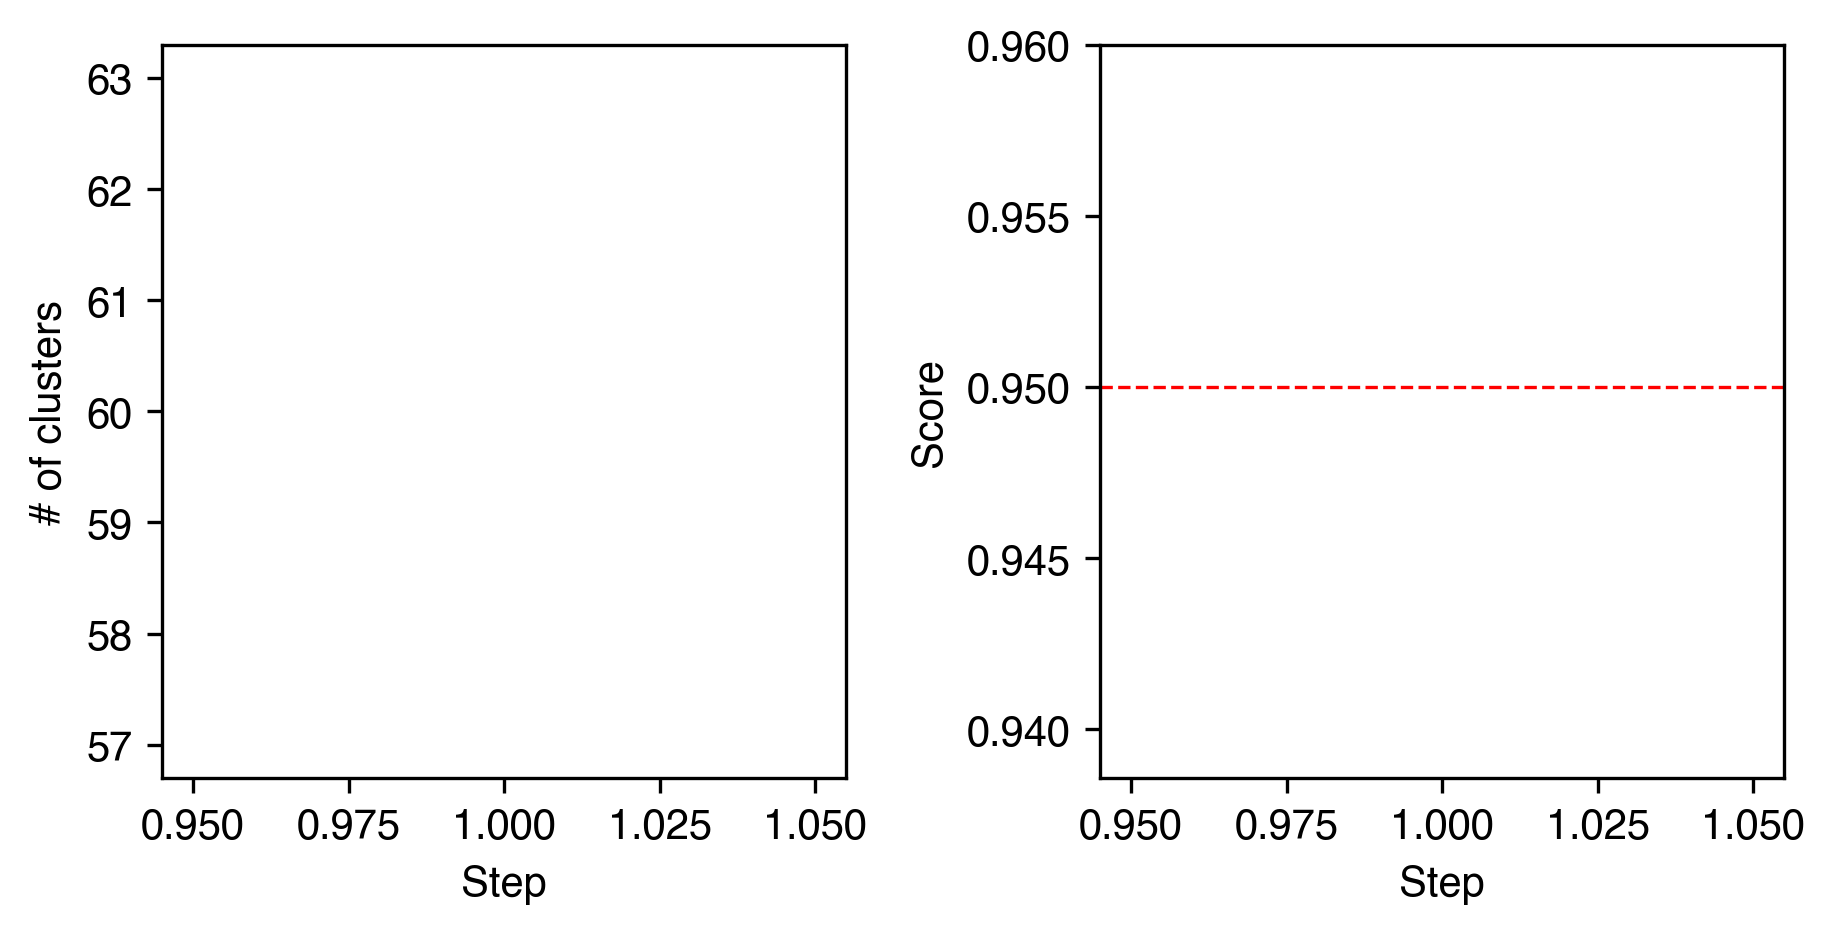

In [24]:
cc.plot_merge_process(plot_size=3)

## Plot ConsensusClustering Details

### Individual Leiden runs with different random states

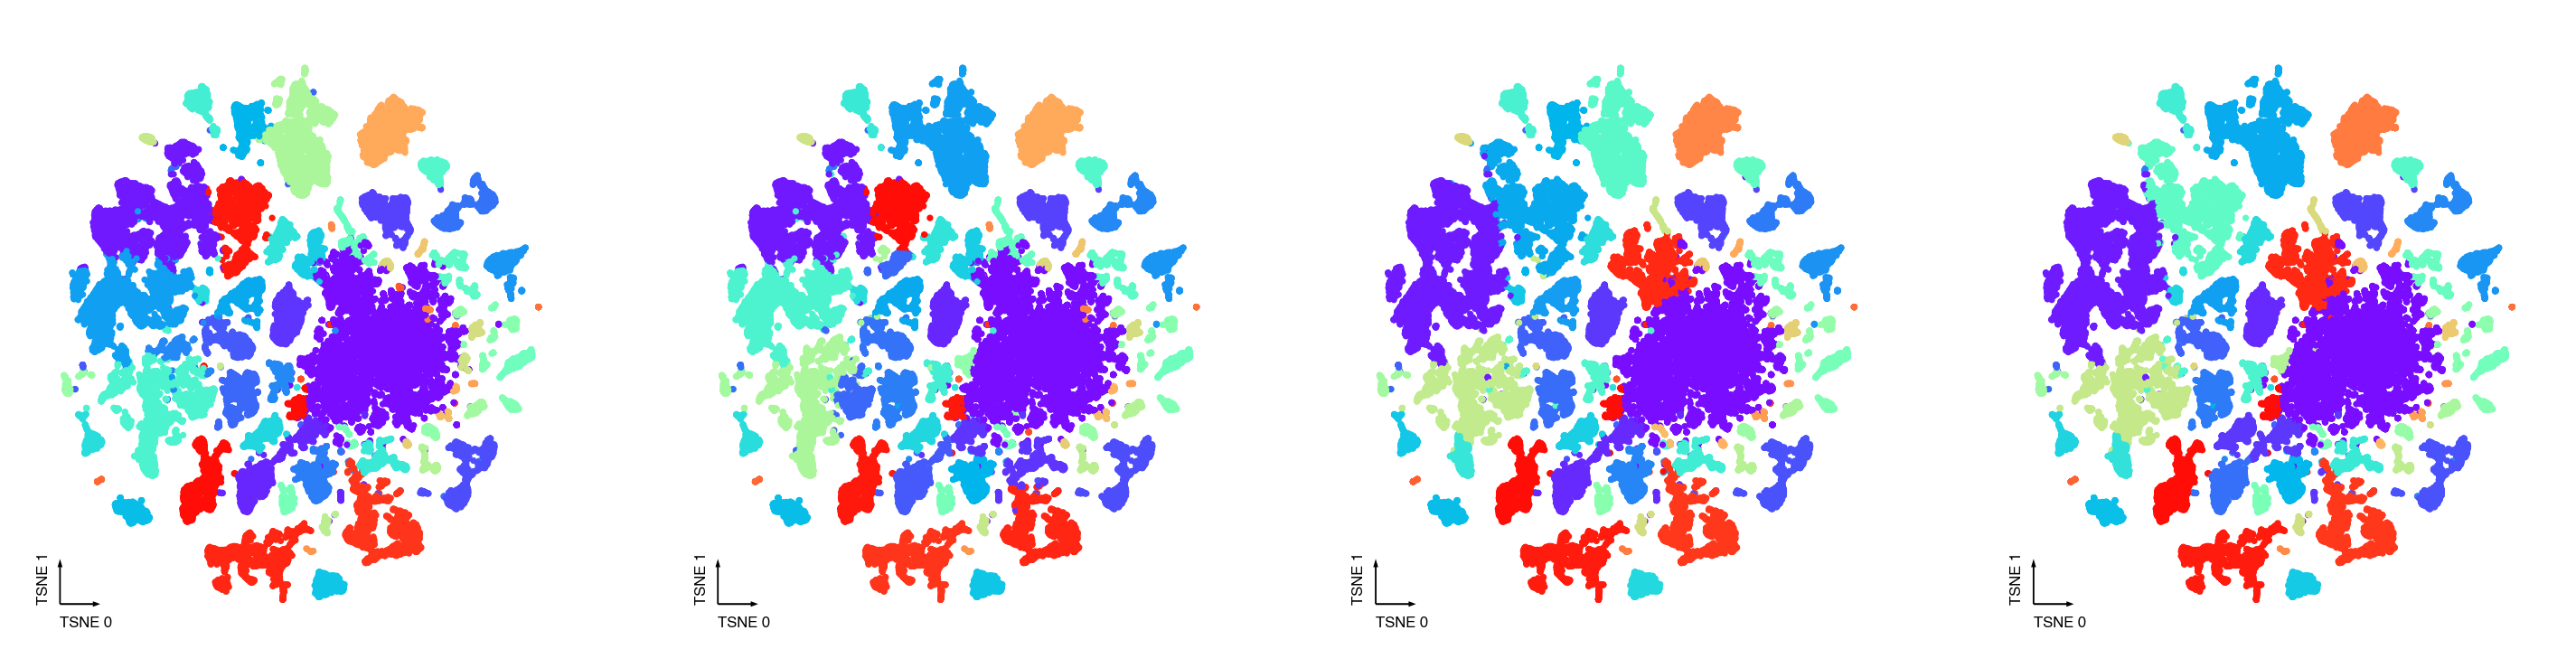

In [23]:
fig, axes = cc.plot_leiden_cases(coord_data=adata,
                                 coord_base=coord_base)

### Merging steps

In [ ]:
len(set(cc._multi_leiden_clusters)), len(set(cc.label))

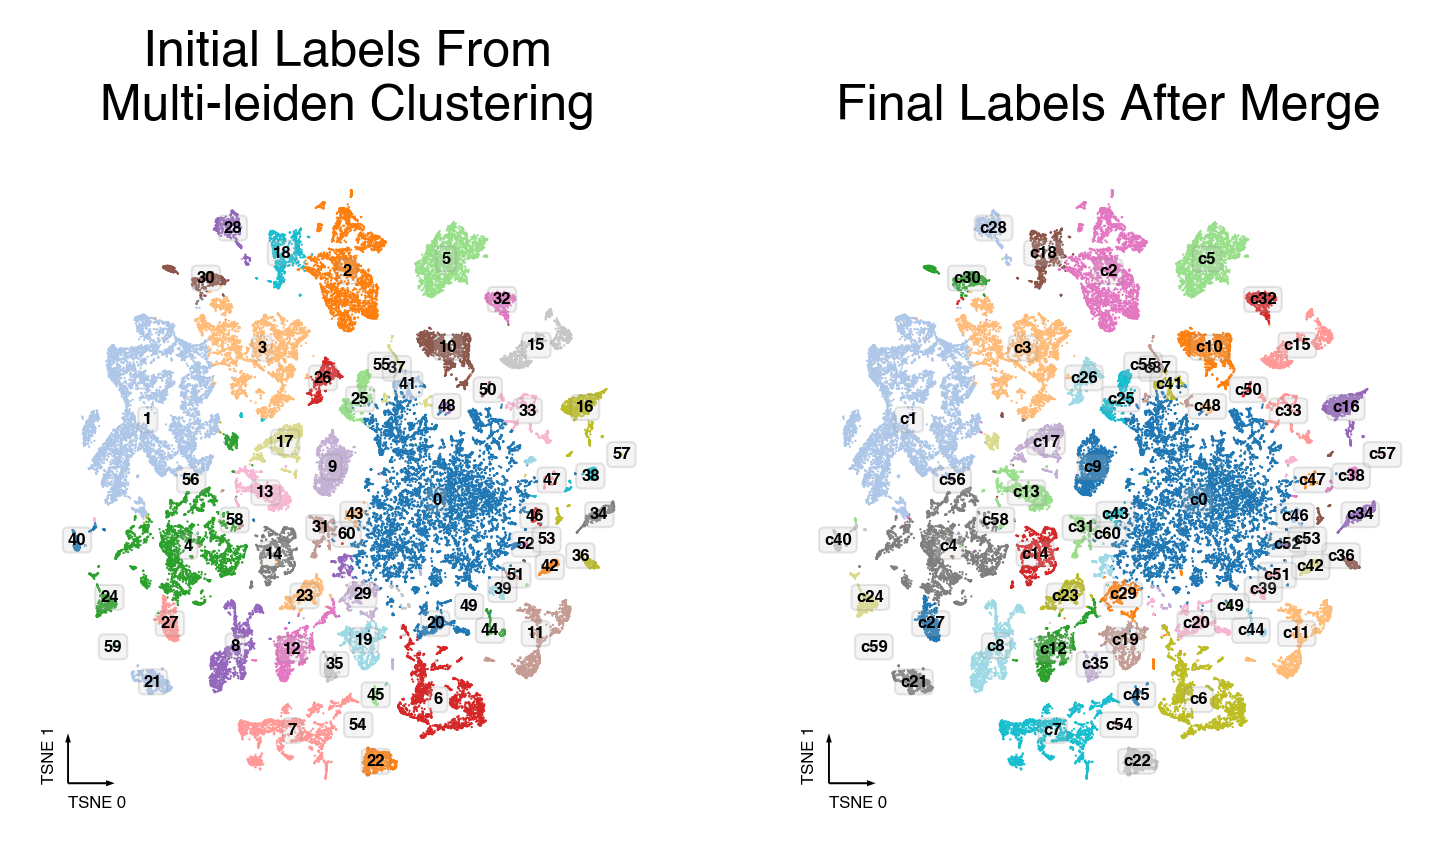

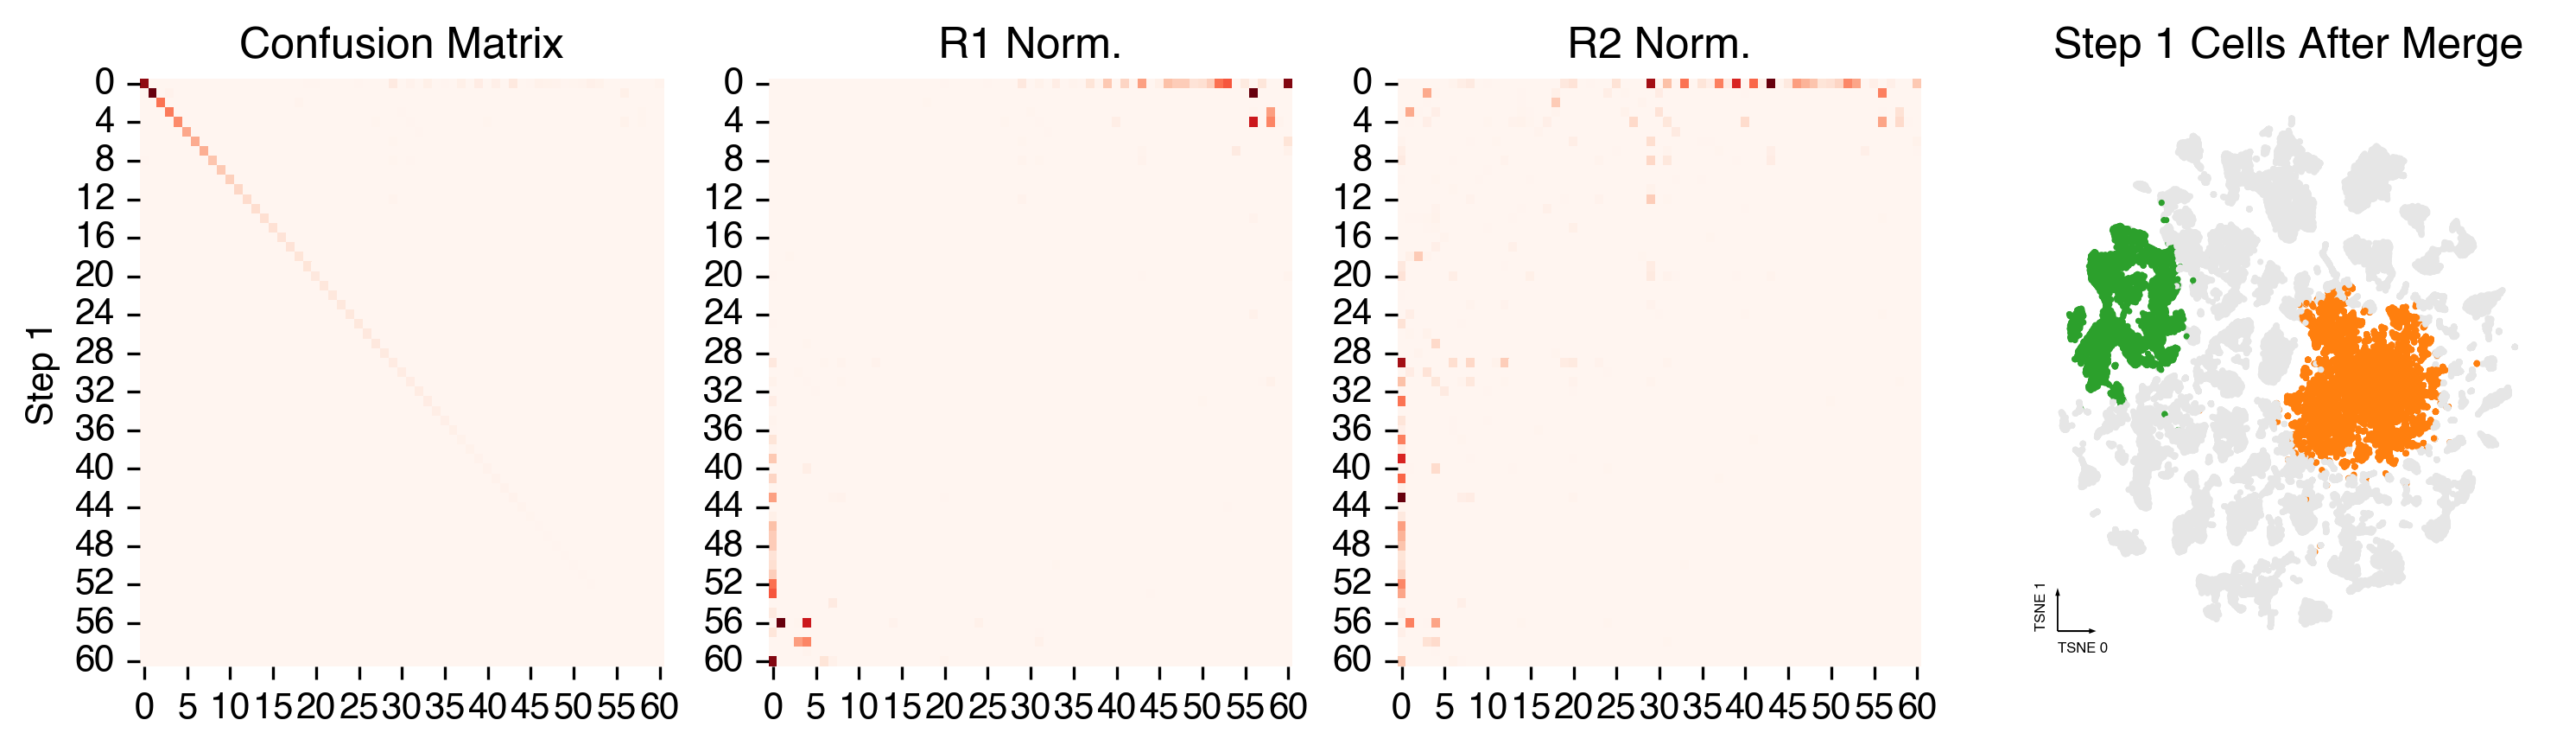

In [22]:
cc.plot_steps(coord_data=adata, coord_base=coord_base)

## Plot Final Clustering Results

### Cluster Lables

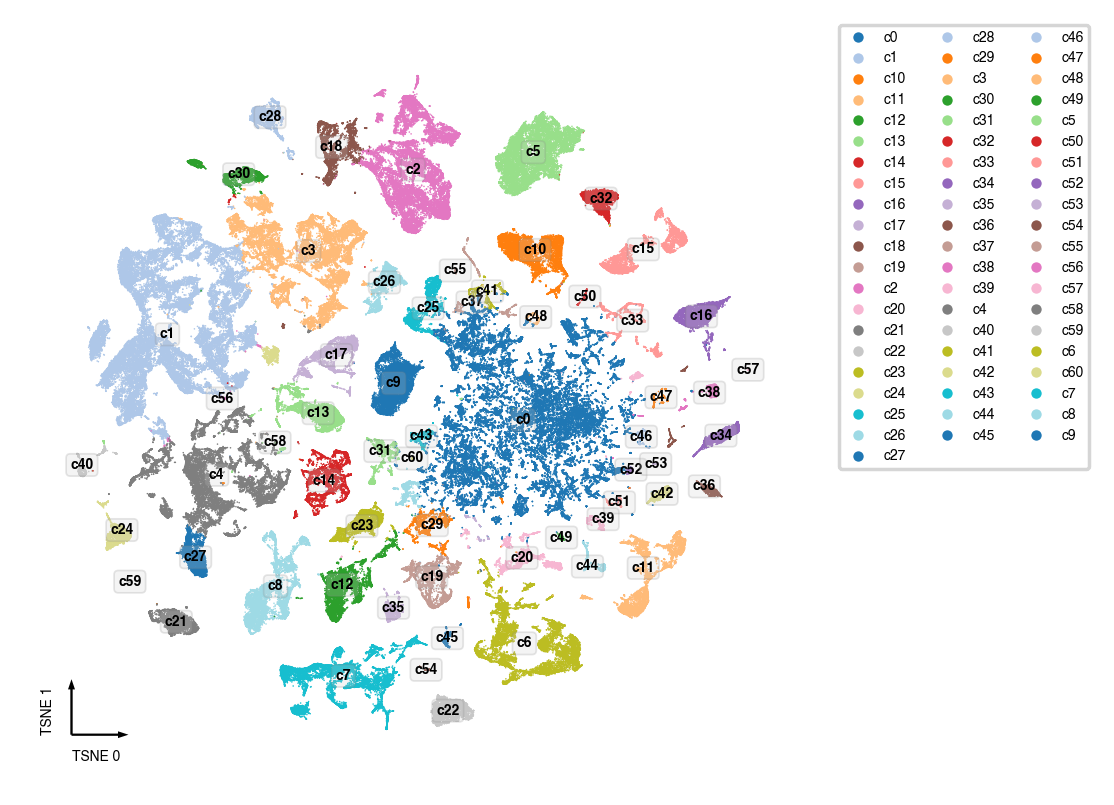

In [21]:
adata.obs[clustering_name] = cc.label

fig, ax = plt.subplots(figsize=(4, 4), dpi=250)
_ = categorical_scatter(data=adata,
                        ax=ax,
                        hue=clustering_name,
                        coord_base=coord_base,
                        palette='tab20',
                        text_anno=clustering_name,
                        show_legend=True,
                        max_points=None)

### Final Prediction Probability

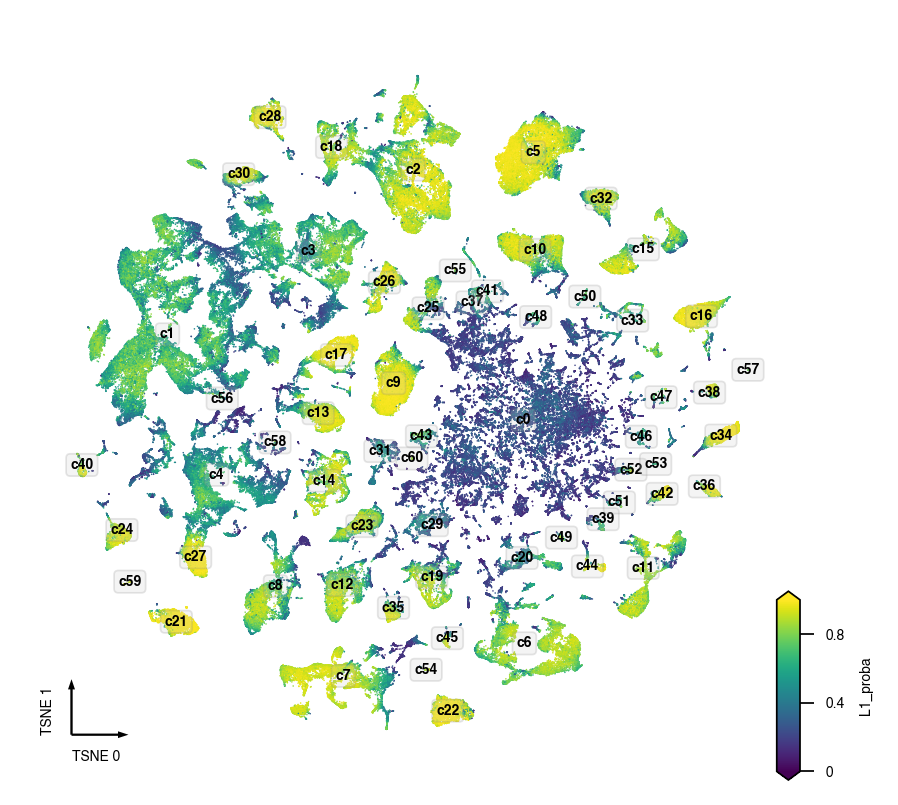

In [20]:
adata.obs[clustering_name + '_proba'] = cc.label_proba

fig, ax = plt.subplots(figsize=(4, 4), dpi=250)
_ = continuous_scatter(data=adata,
                       ax=ax,
                       hue_norm=(0, 1),
                       hue=clustering_name + '_proba',
                       text_anno=clustering_name,
                       coord_base=coord_base,
                       max_points=None)

### Prediction Probability Per Cluster

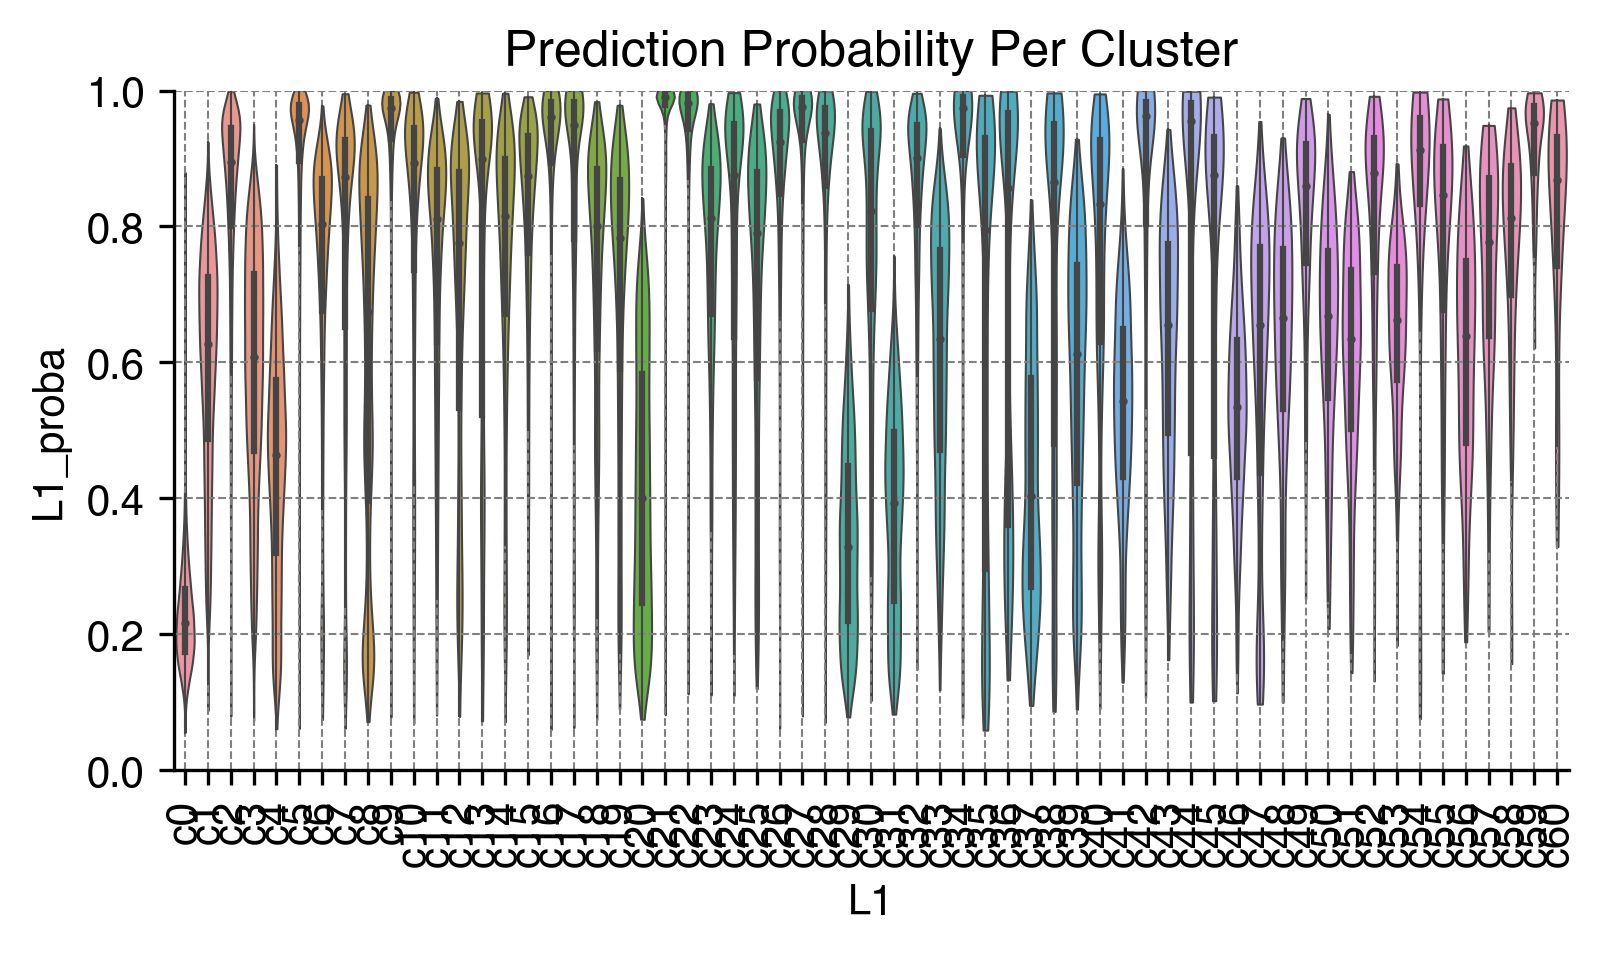

In [19]:
fig, ax = plt.subplots(figsize=(6, 3), dpi=300)

sns.violinplot(data=adata.obs,
               x=clustering_name,
               y=clustering_name + '_proba',
               scale='width',
               linewidth=0.5,
               cut=0,
               ax=ax)
ax.set(ylim=(0, 1), title='Prediction Probability Per Cluster')
ax.xaxis.set_tick_params(rotation=90)
ax.grid(linewidth=0.5, color='gray', linestyle='--')
sns.despine(ax=ax)

## Save

In [ ]:
adata.write_h5ad(adata_path)

In [ ]:
cc.save(f'ConcensusClustering.model.lib')